In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pypsa

In [91]:
run = "nresults_full_3H_ws"
prefix = "/mnt/c/Users/scl38887/Documents/git/aldehyde/workflow/subworkflows/pypsa-earth-sec/results/" + run + "/postnetworks/"
output = "/mnt/c/Users/scl38887/Documents/git/aldehyde/results/" + run + "/graphics/rldc/"

In [108]:
path = "elec_s_10_ec_lc1.0_Co2L0.50_3H_2030_0.15_DF_20export.nc"
n = pypsa.Network(prefix + path)

INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.50_3H_2030_0.15_DF_20export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [78]:
def calculate_rlc(n, resample, incl_curtailment, incl_hy_load, time_sorted):

    # Get load
    load_local = n.loads_t.p_set[n.loads[n.loads.carrier == "AC"].index].sum(axis=1)
    load_electrolysis = n.links_t.p0.loc[:, n.links.carrier == "H2 Electrolysis"].sum(axis=1)

    # Get feed-in of wind 
    wind_power = n.generators.p_nom_opt[n.generators[n.generators.carrier == "onwind"].index]
    wind_profile = n.generators_t.p_max_pu[n.generators[n.generators.carrier == "onwind"].index]
    wind_feed_in = n.generators_t.p[n.generators[n.generators.carrier == "onwind"].index].sum(axis=1)
    wind_feed_in_max = (wind_power * wind_profile).sum(axis=1)    

    # Get feed-in of solar
    solar_power = n.generators.p_nom_opt[n.generators[n.generators.carrier == "solar"].index]
    solar_profile = n.generators_t.p_max_pu[n.generators[n.generators.carrier == "solar"].index]
    solar_feed_in = n.generators_t.p[n.generators[n.generators.carrier == "solar"].index].sum(axis=1)
    solar_feed_in_max = (solar_power * solar_profile).sum(axis=1)

    if incl_hy_load == True:
        load = load_local + load_electrolysis
    elif incl_hy_load == False:
        load = load_local

    # Calculate residual load, if we don't consider curtailment
    if incl_curtailment == False:
        rlc = load - wind_feed_in_max - solar_feed_in_max
    elif incl_curtailment == True:
        rlc = load - wind_feed_in - solar_feed_in

    # Average hourly, daily, weekly
    if resample != False:
        rlc = rlc.resample(resample).mean().ffill()

    if time_sorted == True:
        # Sort residual load
        rlc = rlc.sort_values(ascending=False)
        rlc = rlc.reset_index(drop=True)

    return rlc

In [417]:
def reverse_mitigation(m):
    # if m is bigger than 1, set it to 1
    if m > 1:
        m = 1
    return int(np.round((1 - m)*100, 4))   

INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.10_1H_2030_0.15_DF_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


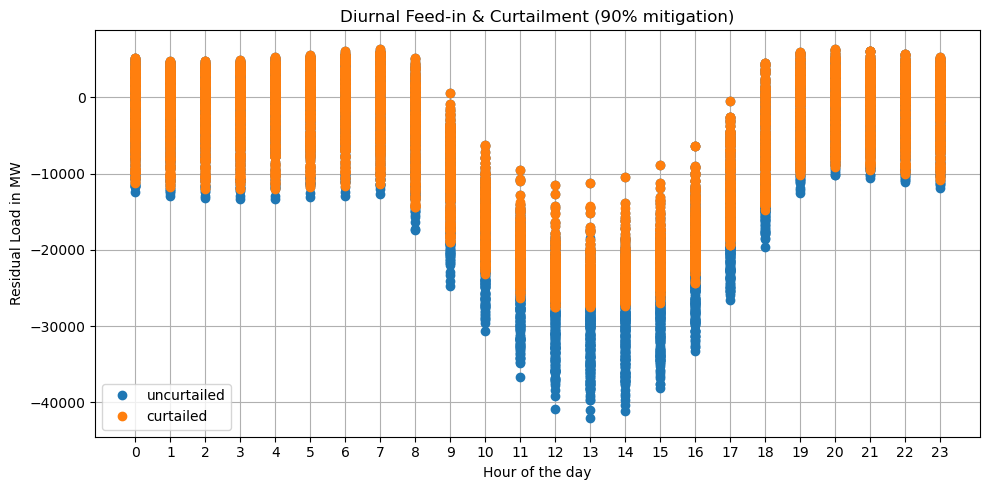

In [424]:
#resampling = "H"
incl_curtailed = True

#xlabel = {"H": "Hours", "D": "Days", "W": "Weeks"}
mitigation = [0.10] #[2.0, 0.90, 0.80, 0.70, 0.60, 0.50, 0.40, 0.30, 0.20, 0.10]

fig = plt.figure(figsize=(10, 5))

# Get and plot the data
for m in mitigation:

    m = str(m) + "0" if m < 1 else str(m) 
    path = "elec_s_10_ec_lc1.0_Co2L" + str(m) + "_1H_2030_0.15_DF_0export.nc"
    n = pypsa.Network(prefix + path)
    
    rlc = calculate_rlc(n, False, False, False)
    average_day = rlc.resample('H').mean()
    rlc_curtail = calculate_rlc(n, False, True, False)
    average_day_curtailed = rlc_curtail.resample('H').mean()
    plt.plot(average_day_curtailed.index.hour, average_day_curtailed, marker='o', linestyle= 'none', label = 'uncurtailed')
    plt.plot(average_day.index.hour, average_day, marker='o', linestyle= 'none', label = 'curtailed')

# Add a title
plt.title("Diurnal Feed-in & Curtailment (90% mitigation)")

# Add axis labels
plt.xlabel('Hour of the day')
plt.ylabel("Residual Load in MW")
#plt.xlim(0, 23)
plt.xticks(range(0, 24))
plt.legend(loc="lower left")
plt.grid()

plt.tight_layout()
plt.savefig(output + "rlc_diurnal_curtdiff" + ".pdf")
plt.show()

INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L2.0_1H_2030_0.15_DF_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.90_1H_2030_0.15_DF_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.80_1H_2030_0.15_DF_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.70_1H_2030_0.15_DF_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.60_1H_2030_0.15_DF_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.50_1H_2030_0.15_DF_0export.nc has b

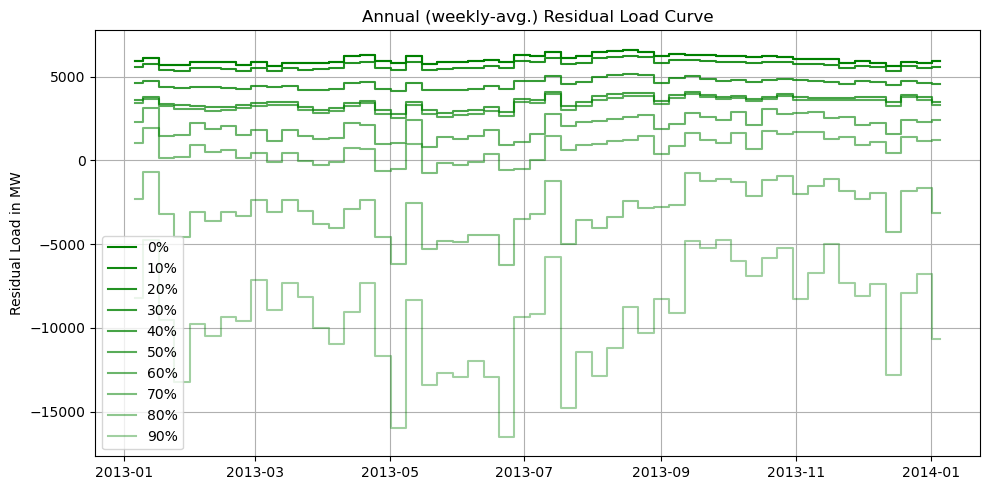

In [419]:
#resampling = "H"
incl_curtailed = True

#xlabel = {"H": "Hours", "D": "Days", "W": "Weeks"}
mitigation = [2.0, 0.90, 0.80, 0.70, 0.60, 0.50, 0.40, 0.30, 0.20, 0.10] #[2.0, 0.50, 0.10]

fig = plt.figure(figsize=(10, 5))

# Get and plot the data
for m in mitigation:

    m = str(m) + "0" if m < 1 else str(m) 
    path = "elec_s_10_ec_lc1.0_Co2L" + str(m) + "_1H_2030_0.15_DF_0export.nc"
    n = pypsa.Network(prefix + path)
    
    rlc = calculate_rlc(n, resample="W", incl_curtailed=incl_curtailed, time_sorted=False)
    plt.step(rlc.index, rlc, where='mid',  label=str(reverse_mitigation(eval(m))) + "%", color="green", alpha=1-reverse_mitigation(eval(m))*0.007)

# Add a title
plt.title("Annual (weekly-avg.) Residual Load Curve")

# Add axis labels
#plt.xlabel('Hour of the day')
plt.ylabel("Residual Load in MW")
#plt.xlim(0, 23)
#plt.xticks(range(0, 24))
plt.legend(loc="lower left")
plt.grid()

plt.tight_layout()
plt.savefig(output + "rlc_annual" + "_inclCurt" + str(incl_curtailed) + ".pdf")
plt.show()

INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.50_3H_2030_0.15_DF_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.50_3H_2030_0.15_DF_20export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.50_3H_2030_0.15_DF_40export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.50_3H_2030_0.15_DF_60export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.50_3H_2030_0.15_DF_80export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.50_3H_2030_0.15_DF_100export.n

<Figure size 1000x500 with 0 Axes>

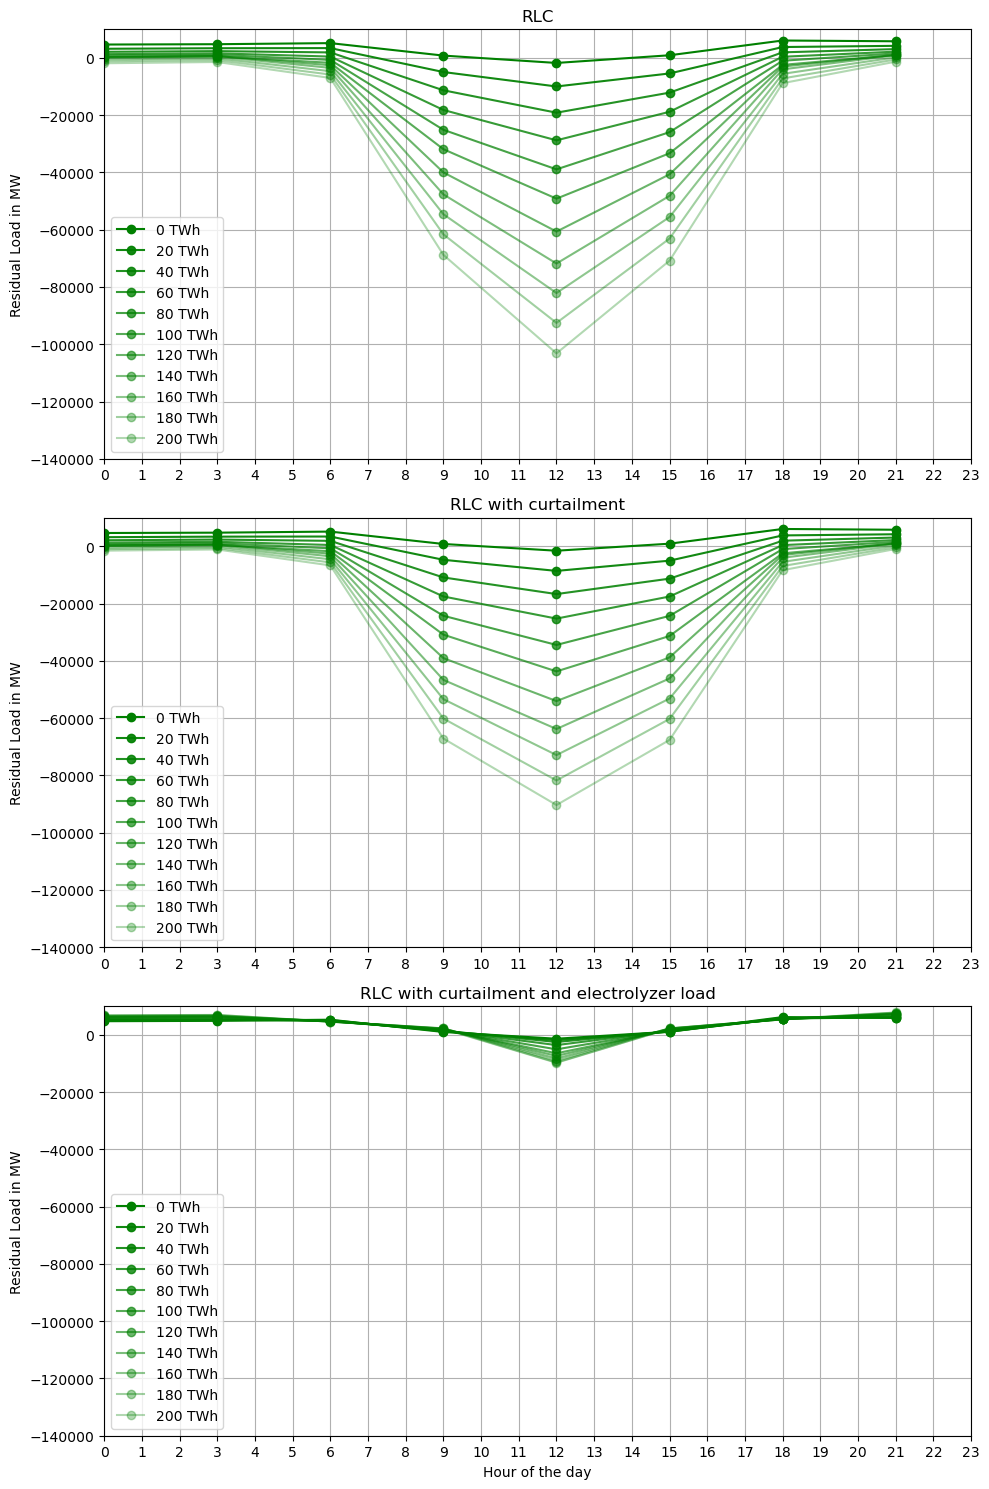

In [89]:
#resampling = "H"
# incl_curtailment = True
# incl_hy_load = True
m = "0.50"
export = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200]


fig = plt.figure(figsize=(10, 5))
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Get and plot the data
for ex in export:

    path = "elec_s_10_ec_lc1.0_Co2L" + m + "_3H_2030_0.15_DF_" + str(ex) + "export.nc"
    n = pypsa.Network(prefix + path)
    
    rlc = calculate_rlc(n, resample=False, incl_curtailment=False, incl_hy_load=False, time_sorted=False)
    average_day = rlc.groupby(rlc.index.hour).mean()
    axs[0].plot(average_day.index, average_day, marker='o', label=str(ex) + " TWh", color="green", alpha=1-(ex/200)*0.7)
    axs[0].set_title("RLC")

    rlc = calculate_rlc(n, resample=False, incl_curtailment=True, incl_hy_load=False, time_sorted=False)
    average_day = rlc.groupby(rlc.index.hour).mean()
    axs[1].plot(average_day.index, average_day, marker='o', label=str(ex) + " TWh", color="green", alpha=1-(ex/200)*0.7)
    axs[1].set_title("RLC with curtailment")

    rlc = calculate_rlc(n, resample=False, incl_curtailment=True, incl_hy_load=True, time_sorted=False)
    average_day = rlc.groupby(rlc.index.hour).mean()
    axs[2].plot(average_day.index, average_day, marker='o', label=str(ex) + " TWh", color="green", alpha=1-(ex/200)*0.7)
    axs[2].set_title("RLC with curtailment and electrolyzer load")



# Add axis labels
for ax in axs.flat:
    ax.set(ylabel='Residual Load in MW')
    ax.set_xlim(0, 23)
    ax.set_ylim(-140_000, 10_000)
    ax.set_xticks(range(0, 24))
    ax.grid()
    ax.legend(loc="lower left")

plt.xlabel('Hour of the day')

plt.tight_layout()
plt.savefig(output + "rlc_diurnal" + "_m" + m + ".pdf")
plt.show()

INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L2.0_1H_2030_0.15_DF_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.90_1H_2030_0.15_DF_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.80_1H_2030_0.15_DF_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.70_1H_2030_0.15_DF_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.60_1H_2030_0.15_DF_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.50_1H_2030_0.15_DF_0export.nc has b

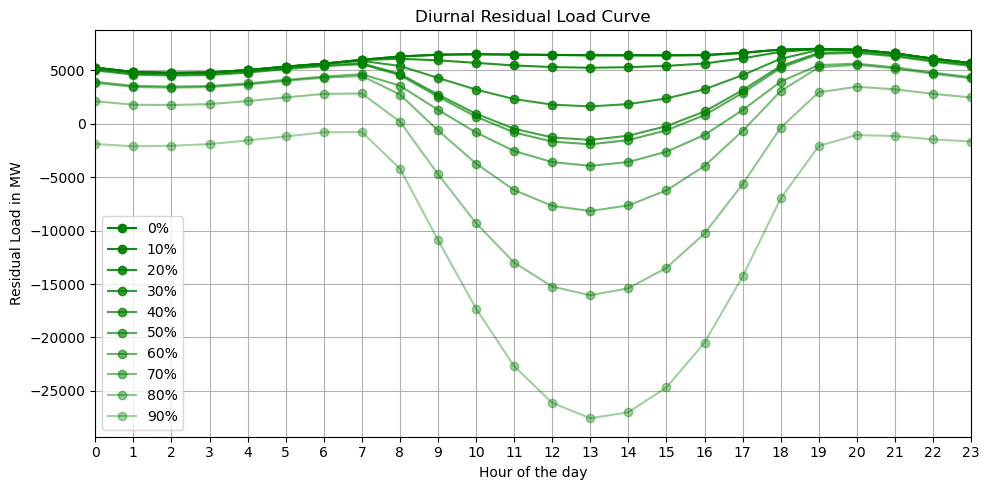

In [ ]:
#resampling = "H"
incl_curtailed = True

#xlabel = {"H": "Hours", "D": "Days", "W": "Weeks"}
mitigation = [2.0, 0.90, 0.80, 0.70, 0.60, 0.50, 0.40, 0.30, 0.20, 0.10] #[2.0, 0.50, 0.10]

fig = plt.figure(figsize=(10, 5))

# Get and plot the data
for m in mitigation:

    m = str(m) + "0" if m < 1 else str(m) 
    path = "elec_s_10_ec_lc1.0_Co2L" + str(m) + "_1H_2030_0.15_DF_0export.nc"
    n = pypsa.Network(prefix + path)
    
    rlc = calculate_rlc(n, resample=False, incl_curtailed=incl_curtailed, time_sorted=False)
    average_day = rlc.groupby(rlc.index.hour).mean()
    #rlc.plot(label=str(reverse_mitigation(eval(m))) + "%", color="green", alpha=1-reverse_mitigation(eval(m))*0.007)

    plt.plot(average_day.index, average_day, marker='o', label=str(reverse_mitigation(eval(m))) + "%", color="green", alpha=1-reverse_mitigation(eval(m))*0.007)

# Add a title
plt.title("Diurnal Residual Load Curve")

# Add axis labels
plt.xlabel('Hour of the day')
plt.ylabel("Residual Load in MW")
plt.xlim(0, 23)
plt.xticks(range(0, 24))
plt.legend(loc="lower left")
plt.grid()

plt.tight_layout()
plt.savefig(output + "rlc_diurnal" + "_inclCurt" + str(incl_curtailed) + ".pdf")
plt.show()

INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L2.0_1H_2030_0.15_DF_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.90_1H_2030_0.15_DF_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.80_1H_2030_0.15_DF_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.70_1H_2030_0.15_DF_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.60_1H_2030_0.15_DF_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.50_1H_2030_0.15_DF_0export.nc has b

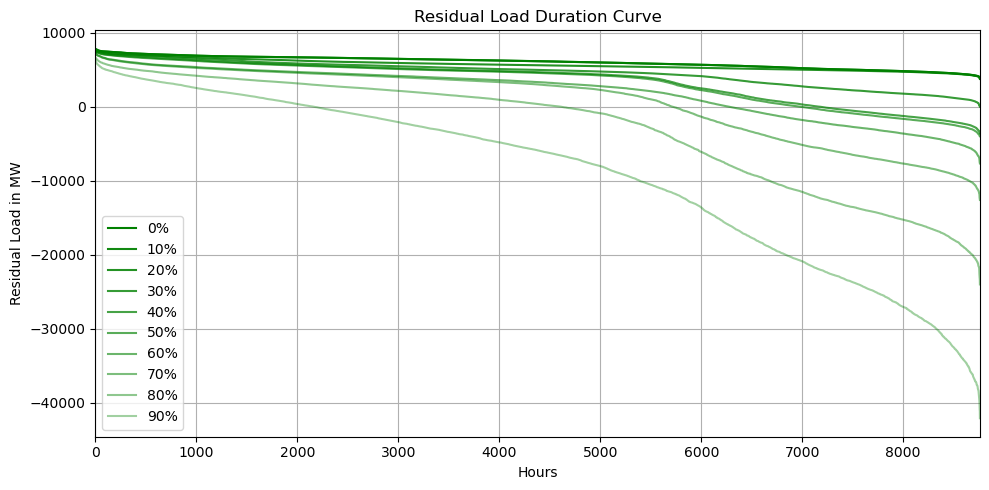

In [421]:
resampling = "H"
incl_curtailed = True

xlabel = {"H": "Hours", "D": "Days", "W": "Weeks"}
mitigation = [2.0, 0.90, 0.80, 0.70, 0.60, 0.50, 0.40, 0.30, 0.20, 0.10]

fig = plt.figure(figsize=(10, 5))

# Get and plot the data
for m in mitigation:

    m = str(m) + "0" if m < 1 else str(m) 
    path = "elec_s_10_ec_lc1.0_Co2L" + str(m) + "_1H_2030_0.15_DF_0export.nc"
    n = pypsa.Network(prefix + path)
    
    rlc = calculate_rlc(n, resample=resampling, incl_curtailed=incl_curtailed, time_sorted=True)
    rlc.plot(label=str(reverse_mitigation(eval(m))) + "%", color="green", alpha=1-reverse_mitigation(eval(m))*0.007)

# Add a title
plt.title("Residual Load Duration Curve")

# Add axis labels
plt.xlabel(xlabel[resampling])
plt.ylabel("Residual Load in MW")
plt.xlim(0, len(rlc))
plt.legend(loc="lower left")
plt.grid()

plt.tight_layout()
plt.savefig(output + "rlc_sorted_" + xlabel[resampling] + "_inclCurt" + str(incl_curtailed) + ".pdf")
plt.show()

In [422]:
# fig = plt.figure(figsize=(30, 5))
# #n.generators_t.p[n.generators[n.generators.carrier == "onwind"].index].sum(axis=1).plot() #.sum() / 1e6 * 3
# wind_power = n.generators.p_nom_opt[n.generators[n.generators.carrier == "onwind"].index]
# wind_profile = n.generators_t.p_max_pu[n.generators[n.generators.carrier == "onwind"].index]
# wind_feed_in = n.generators_t.p[n.generators[n.generators.carrier == "onwind"].index].sum(axis=1)
# (wind_profile * wind_power).sum(axis=1).plot() #.sum() / 1e6 * 3
# wind_feed_in.plot()